Age and Gender Prediction

In [2]:
# import libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import warnings

# import tensorflow and keras
import tensorflow as tf
import keras
from keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
from keras.initializers import random_uniform, glorot_uniform, constant, identity
from keras.layers import Dropout, Input, Add, Dense, Activation,\
    BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, Sequential, load_model
print(dir(keras))



['DTypePolicy', 'FloatDTypePolicy', 'Function', 'Initializer', 'Input', 'InputSpec', 'KerasTensor', 'Layer', 'Loss', 'Metric', 'Model', 'Operation', 'Optimizer', 'Quantizer', 'Regularizer', 'RematScope', 'Sequential', 'StatelessScope', 'SymbolicScope', 'Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_tf_keras', 'activations', 'applications', 'backend', 'callbacks', 'config', 'constraints', 'datasets', 'device', 'distribution', 'dtype_policies', 'export', 'initializers', 'layers', 'legacy', 'losses', 'metrics', 'mixed_precision', 'models', 'name_scope', 'ops', 'optimizers', 'preprocessing', 'quantizers', 'random', 'regularizers', 'remat', 'saving', 'src', 'tree', 'utils', 'version', 'visualization', 'wrappers']


### 1. Load Dataset

In [4]:
from dotenv import load_dotenv

load_dotenv()
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

# import kaggle and download dataset
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.dataset_download_files('jangedoo/utkface-new', path='./datasets', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


In [5]:
print("Files in ./datasets:", os.listdir('./datasets'))

Files in ./datasets: ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']


In [6]:
# Path to the UTKFace dataset
dataset_path = Path("datasets/UTKFace")

# Get all image filenames
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
print(f"Total images found: {len(image_files)}")


Total images found: 23708


Format is given as ` _age_gender_race_timestamp.jpg `

We iterate over all image files in dataset, and add to df Dataframe with columns:
- `image_path`
- `age`
- `gender`

In [7]:
age, gender, image_path = [], [], []

for file in image_files:
        
    split = file.split('_')
    if len(split) == 4:
        image_path.append(Path(dataset_path) / file)
        age.append(int(split[0]))
        gender.append(int(split[1]))
    else:
        continue
    
# Create a DataFrame
df = pd.DataFrame({
    'image_path': image_path,
    'age': age,
    'gender' : gender})

df.head()

    

,image_path,age,gender
0,datasets\UTKFace\100_0_0_20170112213500903.jpg...,100,0
1,datasets\UTKFace\100_0_0_20170112215240346.jpg...,100,0
2,datasets\UTKFace\100_1_0_20170110183726390.jpg...,100,1
3,datasets\UTKFace\100_1_0_20170112213001988.jpg...,100,1
4,datasets\UTKFace\100_1_0_20170112213303693.jpg...,100,1


### 2. Data Preprocessing

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  23705 non-null  object
 1   age         23705 non-null  int64 
 2   gender      23705 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 555.7+ KB


*Convert gender to Male and Female labels/categories*

remember to comment out the labelling process so it wont convert again

In [8]:
# df['gender'] = df['gender'].map({0: 'Male', 1: 'Female'})

df['gender'] = df['gender'].astype('category')

df['gender'].value_counts()

gender
0    12391
1    11314
Name: count, dtype: int64

<Axes: ylabel='Count'>

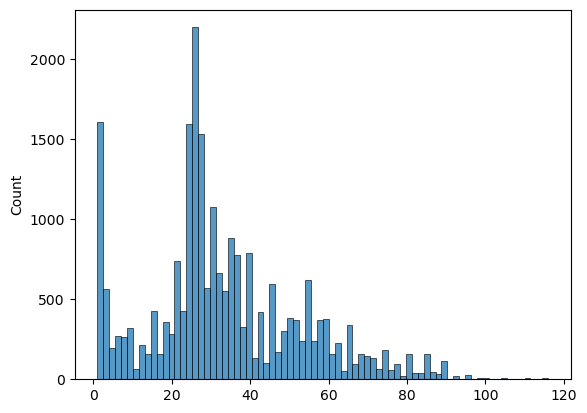

In [9]:
sns.histplot(data = df, x = age)

Gender Distribution is quite balanced. However, the age distribution is highly imbalanced and heavily skewed towards younger individuals. The histogram reveals a significant peak of data points in the 20-30 year-old range, representing the majority of the dataset. This data imbalance is a critical factor that needs to be addressed before training the CNN model.

**Impact on the CNN Model:**

The model is highly likely to become biased towards the heavily represented age groups (e.g., 20s and 30s). This will lead to excellent prediction accuracy for these ages but poor generalization and significant performance degradation on underrepresented age groups, particularly for older individuals. The model will struggle to accurately predict the age of individuals in these categories, often defaulting to a more common age from the training set.

Hence, it is crucial to implement data balancing techniques such as oversampling the minority classes, undersampling the majority classes, or using weighted loss functions during model training.

### 3. Balancing Dataset

To ensure better model generalization and avoid bias toward certain age groups, we apply two techniques to balance the dataset:

1. **Age Capping**: Ages greater than 100 are capped at 100. This simplifies rare outliers and allows the model to generalize better without being skewed by very high ages.

2. **Class Balancing (Age Distribution)**: We analyze the distribution of age labels and perform class balancing:
   - **Upsample** underrepresented age groups (rare ages with few samples).
   - **Downsample** overrepresented age groups (common ages with too many samples).
   - This helps prevent the model from overfitting to frequent ages and improves performance on rare ones.

In [10]:
# put those with age >= 100 as just 100
df['age'] = df['age'].apply(lambda x: 100 if x >= 100 else x)
# Step 1 is done!

age_counts = df['age'].value_counts().sort_values()
for i in range(100):
    if i not in age_counts.index:
        print(i)
print(age_counts)

0
94
97
98
age
91       2
93       5
95       9
99       9
87      10
      ... 
24     859
35     880
28     918
1     1123
26    2197
Name: count, Length: 97, dtype: int64


##### I will need to find images for 94, 97, 98 and upsample for ages 91, 94, 97, 98 until there are 5 samples each. And then downsample ages 1 and 26 to just 1k images, in order to balance the age distribution.

In [11]:
new_rows = pd.DataFrame({
    'age': [94, 97, 98],
    'image_path': [Path('UTKFace_augmented/age_94_lady.jpg'), Path('UTKFace_augmented/age_97_lady.jpg'), Path('UTKFace_augmented/age_97_lady.jpg')],
    'gender': [1, 1, 1]
})

df = pd.concat([df, new_rows], ignore_index=True, sort=False)

#check if the new rows are added
df.tail()


,image_path,age,gender
23703,datasets\UTKFace\9_1_4_20170103200814791.jpg.c...,9,1
23704,datasets\UTKFace\9_1_4_20170103213057382.jpg.c...,9,1
23705,UTKFace_augmented\age_94_lady.jpg,94,1
23706,UTKFace_augmented\age_97_lady.jpg,97,1
23707,UTKFace_augmented\age_97_lady.jpg,98,1


In [12]:
# Image Augmentation Strategy
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly translate images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly translate images vertically (fraction of total height)
    brightness_range=[0.8, 1.2],  # Randomly change brightness
    shear_range=0.1,  # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.1, # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'
)

In [13]:
# Create a folder for augmented images, comment out after creating it
# to avoid re-creating it every time
augmented_path = Path("UTKFace_augmented")
# augmented_path.mkdir(exist_ok=True)

In [14]:
target_ages = [91, 94, 97, 98]
image_size = (200, 200)

subset = df[df['age'].isin(target_ages)]
print(subset)

                                              image_path  age  gender
23484  datasets\UTKFace\91_0_1_20170117194736477.jpg....   91       0
23485  datasets\UTKFace\91_1_2_20170105174644734.jpg....   91       1
23705                  UTKFace_augmented\age_94_lady.jpg   94       1
23706                  UTKFace_augmented\age_97_lady.jpg   97       1
23707                  UTKFace_augmented\age_97_lady.jpg   98       1


In [15]:
for index, row in subset.iterrows():
    # Construct the full image path
    if 'chip' in str(row.image_path):
        original_img_path = Path(f"{row.image_path}")
    else:
        original_img_path = Path(f"{row.image_path}")

    try:
        # Load the image
        img = Image.open(original_img_path)
        # Convert to NumPy array and expand dimensions to create a batch (1, height, width, channels)
        # ImageDataGenerator expects a batch of images, even if it's just one
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

        i = 0
        # ➤ Starts generating new augmented versions of your original image — one at a time (batch_size=1).
        # Use .flow() with the image array
        for batch in datagen.flow(img_array, batch_size=1):
            # 'batch' will be a NumPy array of shape (1, height, width, channels)
            # Extract the single augmented image from the batch
            augmented_image_array = batch[0]
            
            # Convert the NumPy array back to a PIL Image
            augmented_image = array_to_img(augmented_image_array)
            
            # Save the augmented image
            augmented_image_path = augmented_path / f"{row.age}_{row.gender}_{i}.jpg"
            augmented_image.save(augmented_image_path)
            print(f"Saved augmented image: {augmented_image_path}")
            
            # Increment the counter
            i += 1
            if i >= 5:  # Save 5 augmented images per original image
                break
    except Exception as e:
        print(f"Error processing {original_img_path}: {e}")
        continue
    

Saved augmented image: UTKFace_augmented\91_0_0.jpg
Saved augmented image: UTKFace_augmented\91_0_1.jpg
Saved augmented image: UTKFace_augmented\91_0_2.jpg
Saved augmented image: UTKFace_augmented\91_0_3.jpg
Saved augmented image: UTKFace_augmented\91_0_4.jpg
Saved augmented image: UTKFace_augmented\91_1_0.jpg
Saved augmented image: UTKFace_augmented\91_1_1.jpg
Saved augmented image: UTKFace_augmented\91_1_2.jpg
Saved augmented image: UTKFace_augmented\91_1_3.jpg
Saved augmented image: UTKFace_augmented\91_1_4.jpg
Saved augmented image: UTKFace_augmented\94_1_0.jpg
Saved augmented image: UTKFace_augmented\94_1_1.jpg
Saved augmented image: UTKFace_augmented\94_1_2.jpg
Saved augmented image: UTKFace_augmented\94_1_3.jpg
Saved augmented image: UTKFace_augmented\94_1_4.jpg
Saved augmented image: UTKFace_augmented\97_1_0.jpg
Saved augmented image: UTKFace_augmented\97_1_1.jpg
Saved augmented image: UTKFace_augmented\97_1_2.jpg
Saved augmented image: UTKFace_augmented\97_1_3.jpg
Saved augmen

In [16]:
# Get all augmented image files
augmented_files = [f for f in os.listdir(augmented_path) if f.endswith('.jpg') and not f.startswith('age')]

# Extract age and gender from filename
augmented_data = []
for file in augmented_files:
    parts = file.split('_')
    if len(parts) >= 3:
        age = int(parts[0])
        gender = int(parts[1])
        image_path = augmented_path / file
        augmented_data.append({'image_path': image_path, 'age': age, 'gender': gender})

# Create DataFrame
df_upsampled = pd.DataFrame(augmented_data)

# Combine with original DataFrame
df = pd.concat([df, df_upsampled], ignore_index=True)

# Check the last 26 rows
df.tail(26)

,image_path,age,gender
23707,UTKFace_augmented\age_97_lady.jpg,98,1
23708,UTKFace_augmented\91_0_0.jpg,91,0
23709,UTKFace_augmented\91_0_1.jpg,91,0
23710,UTKFace_augmented\91_0_2.jpg,91,0
23711,UTKFace_augmented\91_0_3.jpg,91,0
23712,UTKFace_augmented\91_0_4.jpg,91,0
23713,UTKFace_augmented\91_1_0.jpg,91,1
23714,UTKFace_augmented\91_1_1.jpg,91,1
23715,UTKFace_augmented\91_1_2.jpg,91,1
23716,UTKFace_augmented\91_1_3.jpg,91,1


#### Downsampling

In [17]:
# Randomly downsample ages 1 and 26 to just 1k images each, removing 123 images from age 1, and 1197 images from age 26
df_downsampled = df.copy()
age_1 = df_downsampled[df_downsampled['age'] == 1]
age_26 = df_downsampled[df_downsampled['age'] == 26]
age_1_downsampled = age_1.sample(n=1000, random_state=42)
age_26_downsampled = age_26.sample(n=1000, random_state=42)

# Step 3: Filter out the original age 1 and age 26 rows from the main DataFrame
# Use .isin() with a list for multiple conditions and ~ for negation
df_other_ages = df_downsampled[~df_downsampled['age'].isin([1, 26])]

# Step 4: Concatenate the downsampled ages with the rest of the DataFrame
# Assuming 'subset' is another DataFrame you want to include.
# If 'subset' is not relevant to this specific downsampling task, remove it.
df_meow = pd.concat([df_other_ages, age_1_downsampled, age_26_downsampled])

# Optional: Verify the new counts
df_meow['age'].value_counts().sort_values()

age
93       5
94       6
98       6
97       6
99       9
      ... 
24     859
35     880
28     918
1     1000
26    1000
Name: count, Length: 100, dtype: int64

<Axes: xlabel='age', ylabel='Count'>

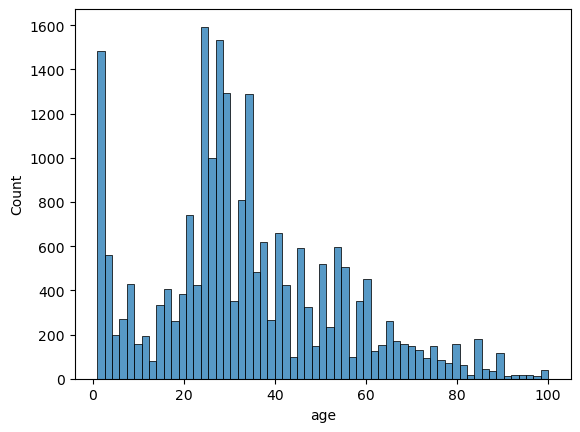

In [18]:
sns.histplot(data = df_meow['age'])

##### *Data is definitely more balanced than before.*

In [19]:
# check if all rows are of Path Type for image_path column

all_paths = df_meow['image_path'].apply(lambda x: isinstance(x, Path)).all()
print("All image paths are Path objects?" , all_paths)

All image paths are Path objects? True


### 4. Split into response and predictor

##### X as predictor(images), y as response(age and gender)

`img_array = img_to_array(img) / 255.0` ->  Converts the image into a NumPy array of pixel values, then divides all values by 255.0. This way, pixel values are within [0, 1] range.

This helps model train better and faster, by standardising + changing from *Python List* to **Numpy Array**

In [20]:
image_size = (200, 200)
X = []
y_age = []
y_gender = []

for idx, row in df_meow.iterrows():
    try:
        img_path = row['image_path']
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        X.append(img_array)
        y_age.append(row['age'])
        y_gender.append(row['gender'])
    except Exception as e:
        print(f"Failed to process {str(img_path)}: {e}") # type: ignore

X = np.array(X)
y_age = np.array(y_age)
y_gender = np.array(y_gender)

### Train-test split

In [21]:
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X, y_age, y_gender, test_size=0.2, random_state=42
)

In [22]:
print(X_train.shape)      
# (batch_size, height, width, channels(RGB))   
print(y_age_train.shape)    
print(y_gender_train.shape) 

(17930, 200, 200, 3)
(17930,)
(17930,)


In [37]:
# get gender distribution
import numpy as np

labels = np.argmax(y_gender_train, axis=1)
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

labels = np.argmax(y_gender_test, axis=1)
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 9496, 1: 8434}
{0: 2320, 1: 2163}


#### 5. Convert gender to binary categories

In [23]:
y_gender_train = tf.keras.utils.to_categorical(y_gender_train, num_classes=2)
y_gender_test = tf.keras.utils.to_categorical(y_gender_test, num_classes=2)

#### 6. Build the CNN model

For each convolution + pooling blocks, 
##### **Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Conv2D(128) → MaxPool**
1) Use 32/64/128 filters of size 3x3 to detect features eg.edges, textures. Increase so that model learns more complex features.
2) Use `padding = same` to add zero around edges of the image, so that output has same width and height as input
3) Normalisation -> **after** `Conv2D` layers and **before** `activation`, to speed up training + reduce overfitting
4) `activation='relu` prevents vanishing gradient problem
- Vanishing gradient happens when the learning vanishes. In deep networks, as you go backward during training (via backpropagation), gradients can get smaller and smaller (approaching zero). Eventually, the early layers stop learning — because the gradient is nearly zero, so no weight updates happen.
5) reduce size with `MaxPooling2D`, keeping important info while shrinking the image
6) `Flatten` converts the 2D output into 1D so it can go into a regular dense layer
7) `Dropout(0.5)` randomly turns off 50% of the neurons during training to prevent overfitting

#### 7. Compile the model

> _It prepares your model for training by telling it:_
1) _How to learn (optimizer)_   = I use `adam` since it is the best choice for beginners and most practical models
2) _What to measure (metrics)_ 
3) _What to minimize (loss function)_

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    input_layer = Input(shape=(200, 200, 3))
    
    x = Conv2D(32, (3,3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    age_output = Dense(1, name='age_output')(x)
    gender_output = Dense(2, activation='softmax', name='gender_output')(x)
    
    model = Model(inputs=input_layer, outputs=[age_output, gender_output])
    lr = hp.Choice('learning_rate', [0.001, 0.005, 0.01, 0.02])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={
            'age_output': 'mse',
            'gender_output': 'categorical_crossentropy'
        },
        metrics={
            'age_output': 'mae',
            'gender_output': 'accuracy'
        }
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('age_output_mae', direction='min'),
    max_trials=10,
    overwrite=True,
    directory='kt_search',
    project_name='age_gender_cnn'
)

tuner.search(X_train, {'age_output': y_age_train, 'gender_output': y_gender_train}, epochs=5, validation_split=0.1)

best_model = tuner.get_best_models(num_models=1)[0]
print('Best learning rate:', tuner.get_best_hyperparameters(1)[0].get('learning_rate'))

Trial 4 Complete [00h 36m 21s]
age_output_mae: 10.682467460632324

Best age_output_mae So Far: 7.927977085113525
Total elapsed time: 02h 27m 20s
Best learning rate: 0.001


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### 8. Train the model

I will be using 10% of the training data to validate the model after each epoch. 

The model updates its weights once per image per epoch.
Batch size = 32, so processing and updating of weights are done in batches, hence faster.

> *Tensorflow auto calculates the loss (how wrong a model is), then uses backpropagation to compute gradients (tell a model how to change weights to reduce loss = gradient descent). Weights are then updated using `adam` optimiser.*

##### Adam Optimiser = Adaptive Moment Estimation:
Because it **adjusts the learning rate for each weight in the model individually**:

- **Big, unstable weights** → get **smaller updates**
- **Slow, consistent weights** → get **bigger updates**

In [ ]:
history = best_model.fit(
    X_train, {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_split=0.15,
    epochs=15,
    batch_size=32
)

Epoch 1/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 468s 902ms/step - age_output_loss: 104.4843 - age_output_mae: 7.8901 - gender_output_accuracy: 0.8646 - gender_output_loss: 0.9657 - loss: 105.4496 - val_age_output_loss: 212.2767 - val_age_output_mae: 11.1618 - val_gender_output_accuracy: 0.8561 - val_gender_output_loss: 0.7208 - val_loss: 212.9094
Epoch 2/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 430s 851ms/step - age_output_loss: 91.7003 - age_output_mae: 7.4206 - gender_output_accuracy: 0.8847 - gender_output_loss: 0.7062 - loss: 92.4067 - val_age_output_loss: 152.2135 - val_age_output_mae: 9.2344 - val_gender_output_accuracy: 0.8661 - val_gender_output_loss: 0.7358 - val_loss: 151.2135
Epoch 3/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 421s 834ms/step - age_output_loss: 87.6898 - age_output_mae: 7.2500 - gender_output_accuracy: 0.8966 - gender_output_loss: 0.5519 - loss: 88.2417 - val_age_output_loss: 103.3696 - val_age_output_mae: 7.8173 - val_gender_output_accuracy: 0.8723 - val_gender_output_loss: 0.6440 - va

🟢 Age Prediction Metrics (regression)
| Metric             | Meaning                                                   |
| ------------------ | --------------------------------------------------------- |
| `age_output_loss`  | Mean Squared Error (how off the predictions are, squared) |
| `age_output_mae`   | Mean Absolute Error (average error in years)              |
| `val_age_output_` | Same as above, but on validation set (unseen data)        |

🟢 Gender Prediction Metrics (classification)
| Metric                       | Meaning                                                      |
| ---------------------------- | ------------------------------------------------------------ |
| `gender_output_accuracy`     | % of genders predicted correctly on training data            |
| `val_gender_output_accuracy` | Same for validation (unseen) data                            |
| `gender_output_loss`         | How wrong the model was on predicting gender (cross-entropy) |


✅ What we can conclude:

1) Model is learning age and gender well
- MAE dropped from 7.8901 → 5.7301 on training
- Validation MAE dropped from 11.1618 → 8.4502

- Gender training accuracy went from 86.46% → 94.58%
- Validation accuracy stayed strong: ~ 86%–88%

2) **No severe overfitting** - Training and validation accuracy/MAE **stay close**


#### 9. Evaluate on test data

In [26]:
best_model.evaluate(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test})

141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - age_output_loss: 128.9203 - age_output_mae: 8.4384 - gender_output_accuracy: 0.8896 - gender_output_loss: 0.6463 - loss: 129.5788


[135.16836547851562,
 133.61026000976562,
 0.6954691410064697,
 8.608955383300781,
 0.8860138058662415]

- 98.73,         # Total combined loss
- 97.55,         # Age prediction loss (MSE)
- 0.8378,        # Gender prediction loss (Cross-Entropy)
- 7.55,          # Age prediction MAE (Mean Absolute Error)
- 0.8784         # Gender prediction accuracy

In [28]:
best_model.save("models/age_gender_model.keras")

#### 10. Plotting of training history
<br> 

#### Training and Validation Curves

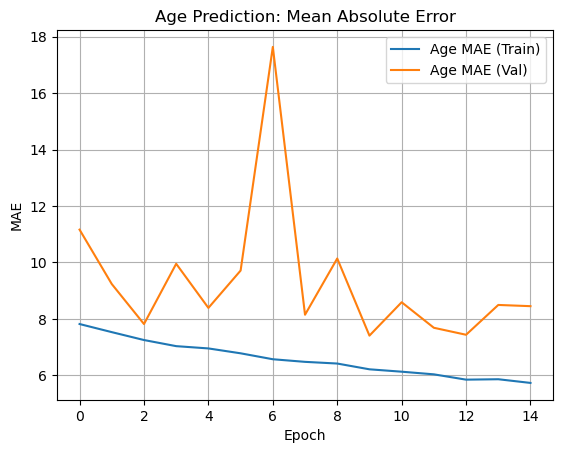

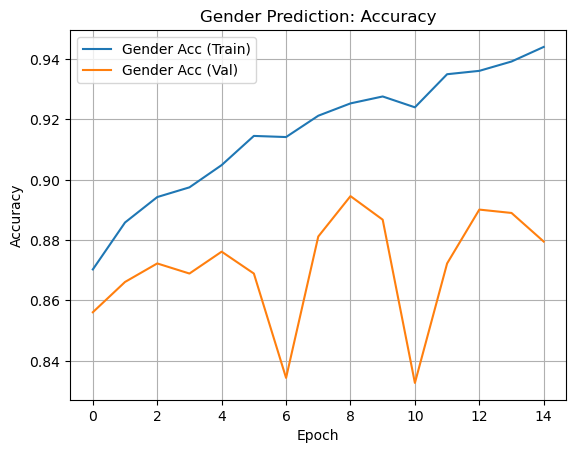

In [29]:
# Plot Age MAE
plt.plot(history.history['age_output_mae'], label='Age MAE (Train)')
plt.plot(history.history['val_age_output_mae'], label='Age MAE (Val)')
plt.title('Age Prediction: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot Gender Accuracy
plt.plot(history.history['gender_output_accuracy'], label='Gender Acc (Train)')
plt.plot(history.history['val_gender_output_accuracy'], label='Gender Acc (Val)')
plt.title('Gender Prediction: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### 1. Age Prediction (Mean Absolute Error)

🔵 Train MAE steadily decreased from ~7.8 to ~5.7 years, showing that my model is consistently learning from the training data.

🟠 Validation MAE is more unstable, with spikes (up to ~18) around epoch 6, before settling between 7–9 years.

My takeaway:

- The training curve looks healthy, but the validation curve shows signs of overfitting and instability.

- My model may be memorizing training examples too well while struggling to generalize to unseen data.

- To improve, I could try Regularization (e.g., L2 weight decay) and more data augmentation.

#### 2. Gender Prediction (Accuracy)

🔵 Train Accuracy improved smoothly, reaching ~94.5%.

🟠 Validation Accuracy fluctuated between 83–89%, without the same steady upward trend.

My takeaway:

The gap between training and validation accuracy suggests overfitting. My model performs very well on the training set but struggles to maintain stable accuracy on validation.

Possible improvements: Add dropout in convolutional layers (not just at the dense layer). Tune batch size or try early stopping with patience to prevent over-training.

#### ✅ Overall Reflection

Age prediction has promising training results but unstable validation MAE, pointing to generalization issues.

Gender prediction shows high training accuracy but fluctuating validation performance, another sign of overfitting.

I’m happy with the direction my model is going (it clearly learns useful patterns), but I recognize I need to work on improving generalization so that it performs more reliably on new data.

#### 11. Build a new CNN Model - Improve Generatlization

##### To solve my overfitting issues:
1) Use a joint objective in my keras tuning, and change objectives to increase accuracy on validation dataset instead, since training accuracy will usually go up anyways.
2) Add L2 regularization with tuning, to pick optimal regularization as well as Learning Rate
3) Add EarlyStoppiong, ReduceLROnPlateau, and ModelCheckpoint
4) Slightly increase validation split

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

# add l2 regularization to conv layers(2)
def build_regularized_model(hp):
    input_layer = Input(shape=(200, 200, 3))
    
    l2_val = hp.Choice("l2_reg", [1e-4, 5e-4])
    x = Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(l2_val))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(l2_val))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(l2_val))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    age_output = Dense(1, name='age_output')(x)
    gender_output = Dense(2, activation='softmax', name='gender_output')(x)
    
    model = Model(inputs=input_layer, outputs=[age_output, gender_output])
    lr = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={
            'age_output': 'mse',
            'gender_output': 'categorical_crossentropy'
        },
        metrics={
            'age_output': 'mae',
            'gender_output': 'accuracy'
        }
    )
    return model

# Create a tuner with joint objectives (1)
tuner = kt.RandomSearch(
    build_regularized_model,
    objective= [
        kt.Objective('val_age_output_mae', direction='min'),
        kt.Objective('val_gender_output_accuracy', direction='max')
    ],
    max_trials=10,
    overwrite=True,
    directory='kt_search',
    project_name='age_gender_cnn'
)

tuner.search(X_train, {'age_output': y_age_train, 'gender_output': y_gender_train}, epochs=4, validation_split=0.2)

best_model = tuner.get_best_models(num_models=1)[0]
print('Best learning rate:', tuner.get_best_hyperparameters(1)[0].get('learning_rate'))

Trial 6 Complete [00h 26m 06s]
multi_objective: 7.727886378765106

Best multi_objective So Far: 7.727886378765106
Total elapsed time: 02h 36m 58s
Best learning rate: 0.0005


c:\Users\linmy\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### 12. Building, Comiling & Training 2nd Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Add EarlyStopping (3)
# Stop training if validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_age_output_mae', etc.
    patience=3,              # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # restore model weights from the epoch with the best value of the monitored quantity
)

# Add ReduceLROnPlateau (3)
# Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

# Save the best model during training (3)
checkpoint = ModelCheckpoint(
    "best_age_gender.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1 # only log when a model is saved
)

history = best_model.fit(
    X_train, {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_split=0.2,
    epochs=16,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

Epoch 1/16
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - age_output_loss: 119.6715 - age_output_mae: 8.4891 - gender_output_accuracy: 0.8470 - gender_output_loss: 1.0091 - loss: 120.6962
Epoch 1: val_loss improved from inf to 151.49672, saving model to best_age_gender.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 400s 875ms/step - age_output_loss: 119.6702 - age_output_mae: 8.4890 - gender_output_accuracy: 0.8470 - gender_output_loss: 1.0091 - loss: 120.6944 - val_age_output_loss: 149.4209 - val_age_output_mae: 9.1425 - val_gender_output_accuracy: 0.7429 - val_gender_output_loss: 2.0408 - val_loss: 151.4967 - learning_rate: 5.0000e-04
Epoch 2/16
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - age_output_loss: 104.6955 - age_output_mae: 7.9552 - gender_output_accuracy: 0.8618 - gender_output_loss: 0.9750 - loss: 105.6876
Epoch 2: val_loss improved from 151.49672 to 132.21992, saving model to best_age_gender.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 384s 854ms/step - age_output_loss: 104.6964 - age_output_mae

#### 🧠 Training Improvements with Callbacks and Regularization

1. Training Dynamics
- Before, the training loss decreased steadily, but the **validation loss was unstable** and often spiked.  
- With **EarlyStopping**, **ReduceLROnPlateau**, and **ModelCheckpoint**, the training process became **more controlled**:
  - EarlyStopping prevented overtraining once validation stopped improving.  
  - ReduceLROnPlateau automatically reduced the learning rate when a metric has stopped learning. 
  - ModelCheckpoint saved the best-performing model (based on validation loss), so I always kept the strongest version.

2. Age Prediction (MAE)
- Training MAE improved from **~8.5 → 5.8** by the end.  
- Validation MAE dropped and became more stable, hovering around **7.0–7.2** compared to ~9+ before.  
- This shows the model is learning age features better and generalizing more consistently on unseen data.

3. Gender Prediction (Accuracy)
- Training gender accuracy improved to **94%+**, higher than previous runs.  
- Validation gender accuracy consistently reached **~89–90%**, compared to ~86–87% earlier.  
- The validation curve is smoother, showing that regularization + callbacks reduced overfitting.

4. Loss Stability
- Validation loss used to fluctuate heavily (sometimes >150).  
- Now, it **dropped steadily to ~88–90**, with much smaller fluctuations.  
- This demonstrates that learning rate scheduling helped the optimizer settle into better minima.


#### 13. Evaluate on Test Set and Save Model

In [42]:
best_model.evaluate(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test})

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - age_output_loss: 87.4042 - age_output_mae: 7.1558 - gender_output_accuracy: 0.9001 - gender_output_loss: 0.6186 - loss: 88.0511


[90.9521713256836,
 89.83338928222656,
 0.6337108016014099,
 7.180645942687988,
 0.8998438715934753]

In [43]:
best_model.save("models/age_gender_model_2.keras")

#### 14. Plot New Training vs Validation Training Curves

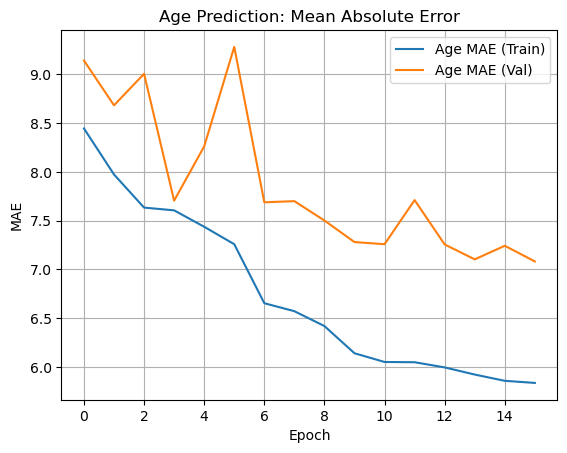

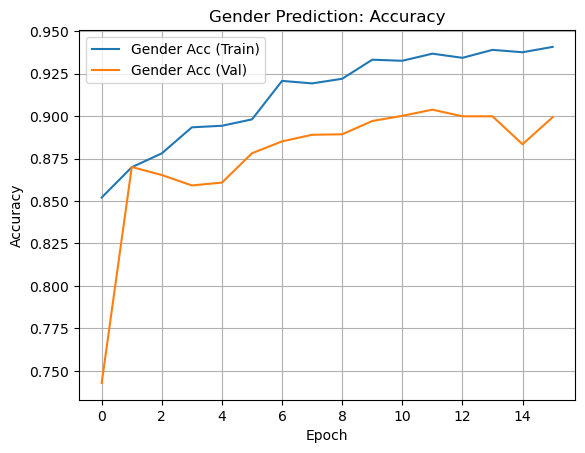

In [44]:
# Plot Age MAE
plt.plot(history.history['age_output_mae'], label='Age MAE (Train)')
plt.plot(history.history['val_age_output_mae'], label='Age MAE (Val)')
plt.title('Age Prediction: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot Gender Accuracy
plt.plot(history.history['gender_output_accuracy'], label='Gender Acc (Train)')
plt.plot(history.history['val_gender_output_accuracy'], label='Gender Acc (Val)')
plt.title('Gender Prediction: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### 📊 Training Results (After Regularization + Callbacks)

1. Age Prediction (MAE)
- **Training MAE** decreased steadily from ~8.5 → 5.8, showing the model is learning age features effectively.  
- **Validation MAE** fluctuated at the start but stabilized around ~7.0–7.2, much lower than earlier runs (~9+).  

2. Gender Prediction (Accuracy)
- **Training accuracy** increased smoothly from ~85% → 94.5%.  
- **Validation accuracy** climbed from ~74% → ~90%, staying close to the training curve.   

3. Key Takeaways
- Both **age MAE** and **gender accuracy** improved compared to prior models. And the smaller gap between training and validation curves, and smoother validation curves indicates reduced overfitting and better generalization, hence with stabilized validation performance, the model was more robust for deployment.


#### 15. Age Prediction Evaluation - Predicted vs Actual Scatter Plot

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step


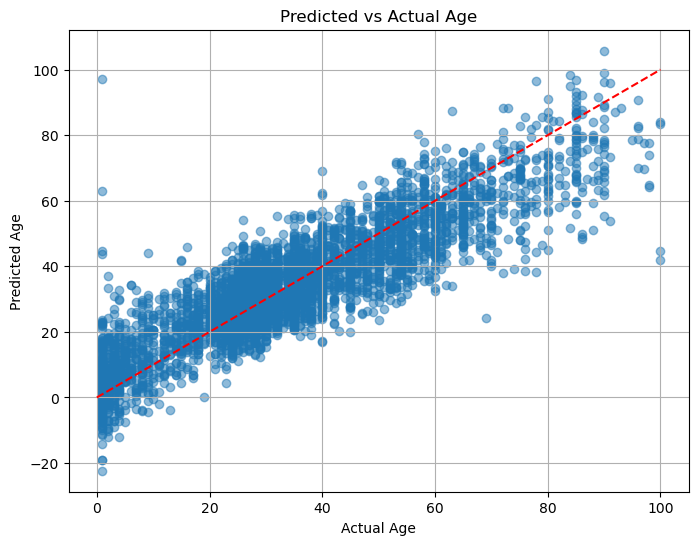

In [45]:
# Get age predictions (output 0 from the model)
y_pred_age = best_model.predict(X_test)[0].flatten()

# Plot predicted vs actual ages
plt.figure(figsize=(8, 6))
plt.scatter(y_age_test, y_pred_age, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')  # ideal line
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs Actual Age')
plt.grid(True)
plt.show()


#### Insights:

- ✅ The model **successfully captures the age distribution trend** with relatively tight clustering along the ideal red line.
- ✅ A small mean absolute error (MAE) and this scatter pattern confirm that the model performs **reasonably well**.
- ⚠️ - There are some outliers:
  - A few predictions below 0 (can be fixed by clamping or using a `ReLU` in the output layer)
  - More scatter and noise at age extremes (e.g. 60+), likely due to fewer samples in those ranges.

> 🎯 Overall, this visual confirms that my CNN is making **informed predictions** and not random guesses.


#### 16. Gender Prediction Evaluation – Classification Report

In [46]:
from sklearn.metrics import classification_report
import numpy as np

# Get gender predictions (output 1 from the model)
y_pred_gender = best_model.predict(X_test)[1]

# Convert one-hot encoded gender back to label
y_pred_gender_labels = np.argmax(y_pred_gender, axis=1)
y_true_gender_labels = np.argmax(y_gender_test, axis=1)

# Generate classification report
print(classification_report(y_true_gender_labels, y_pred_gender_labels, target_names=['Male', 'Female']))

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step
              precision    recall  f1-score   support

        Male       0.89      0.92      0.90      2320
      Female       0.91      0.88      0.89      2163

    accuracy                           0.90      4483
   macro avg       0.90      0.90      0.90      4483
weighted avg       0.90      0.90      0.90      4483



| Class   | Precision | Recall | F1-score | Support | 
|---------|-----------|--------|----------|---------|
| Definition |Out of all the times the model predicted a class, how often was it correct?| Out of all the true samples of a class, how many did the model correctly identify?|  - | - |
| Male    | 0.89      | 0.92   | 0.90     | 2320    |
| Female  | 0.91      | 0.88   | 0.89     | 2163    |

#### Insights:

- ✅ The model achieves a strong **90% overall accuracy** in gender classification.
- ✅ It’s especially strong at identifying **Male** samples (Recall: 92%), meaning it rarely misses when a sample is male.
- ✅ It is more precise when predicting **Female** (Precision: 91%), meaning when it says "Female", it's usually correct.

> 🎯 This confirms that my gender prediction performs well and makes reliable predictions for both classes with balanced precision and recall.
